In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [2]:
TEST_DIR = '/kaggle/input/facial-expression-dataset/test/test'
TRAIN_DIR = '/kaggle/input/facial-expression-dataset/train/train'

In [3]:
import os

def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)  # Correct path joining
        if os.path.isdir(label_path):  # Ensure it's a directory
            for filename in os.listdir(label_path):
                image_path = os.path.join(label_path, filename)  # Use the correct full path
                image_paths.append(image_path)
                labels.append(label)
                
        print(label, "Completed")
        
    return image_paths, labels


In [4]:
import os

print(os.listdir(TRAIN_DIR))



['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [5]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/train/...,sad
1,/kaggle/input/facial-expression-dataset/train/...,sad
2,/kaggle/input/facial-expression-dataset/train/...,happy
3,/kaggle/input/facial-expression-dataset/train/...,neutral
4,/kaggle/input/facial-expression-dataset/train/...,surprise


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


<Axes: xlabel='label', ylabel='count'>

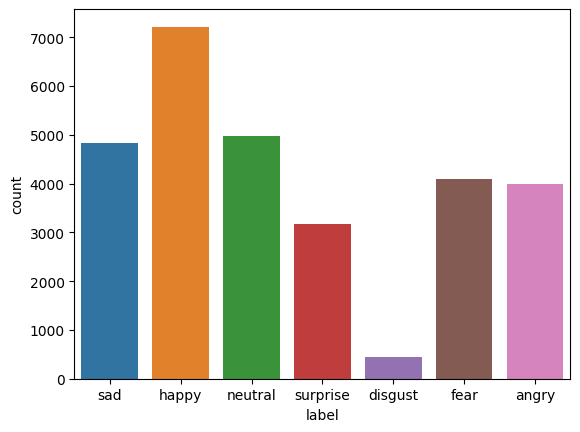

In [7]:
sns.countplot(x='label', data=train)

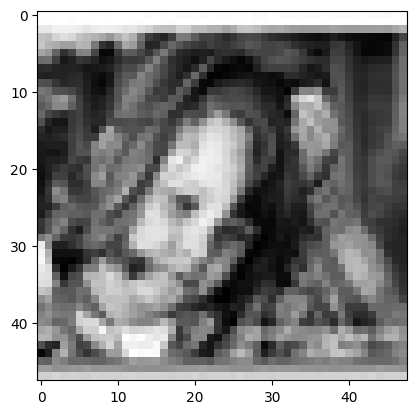

In [8]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

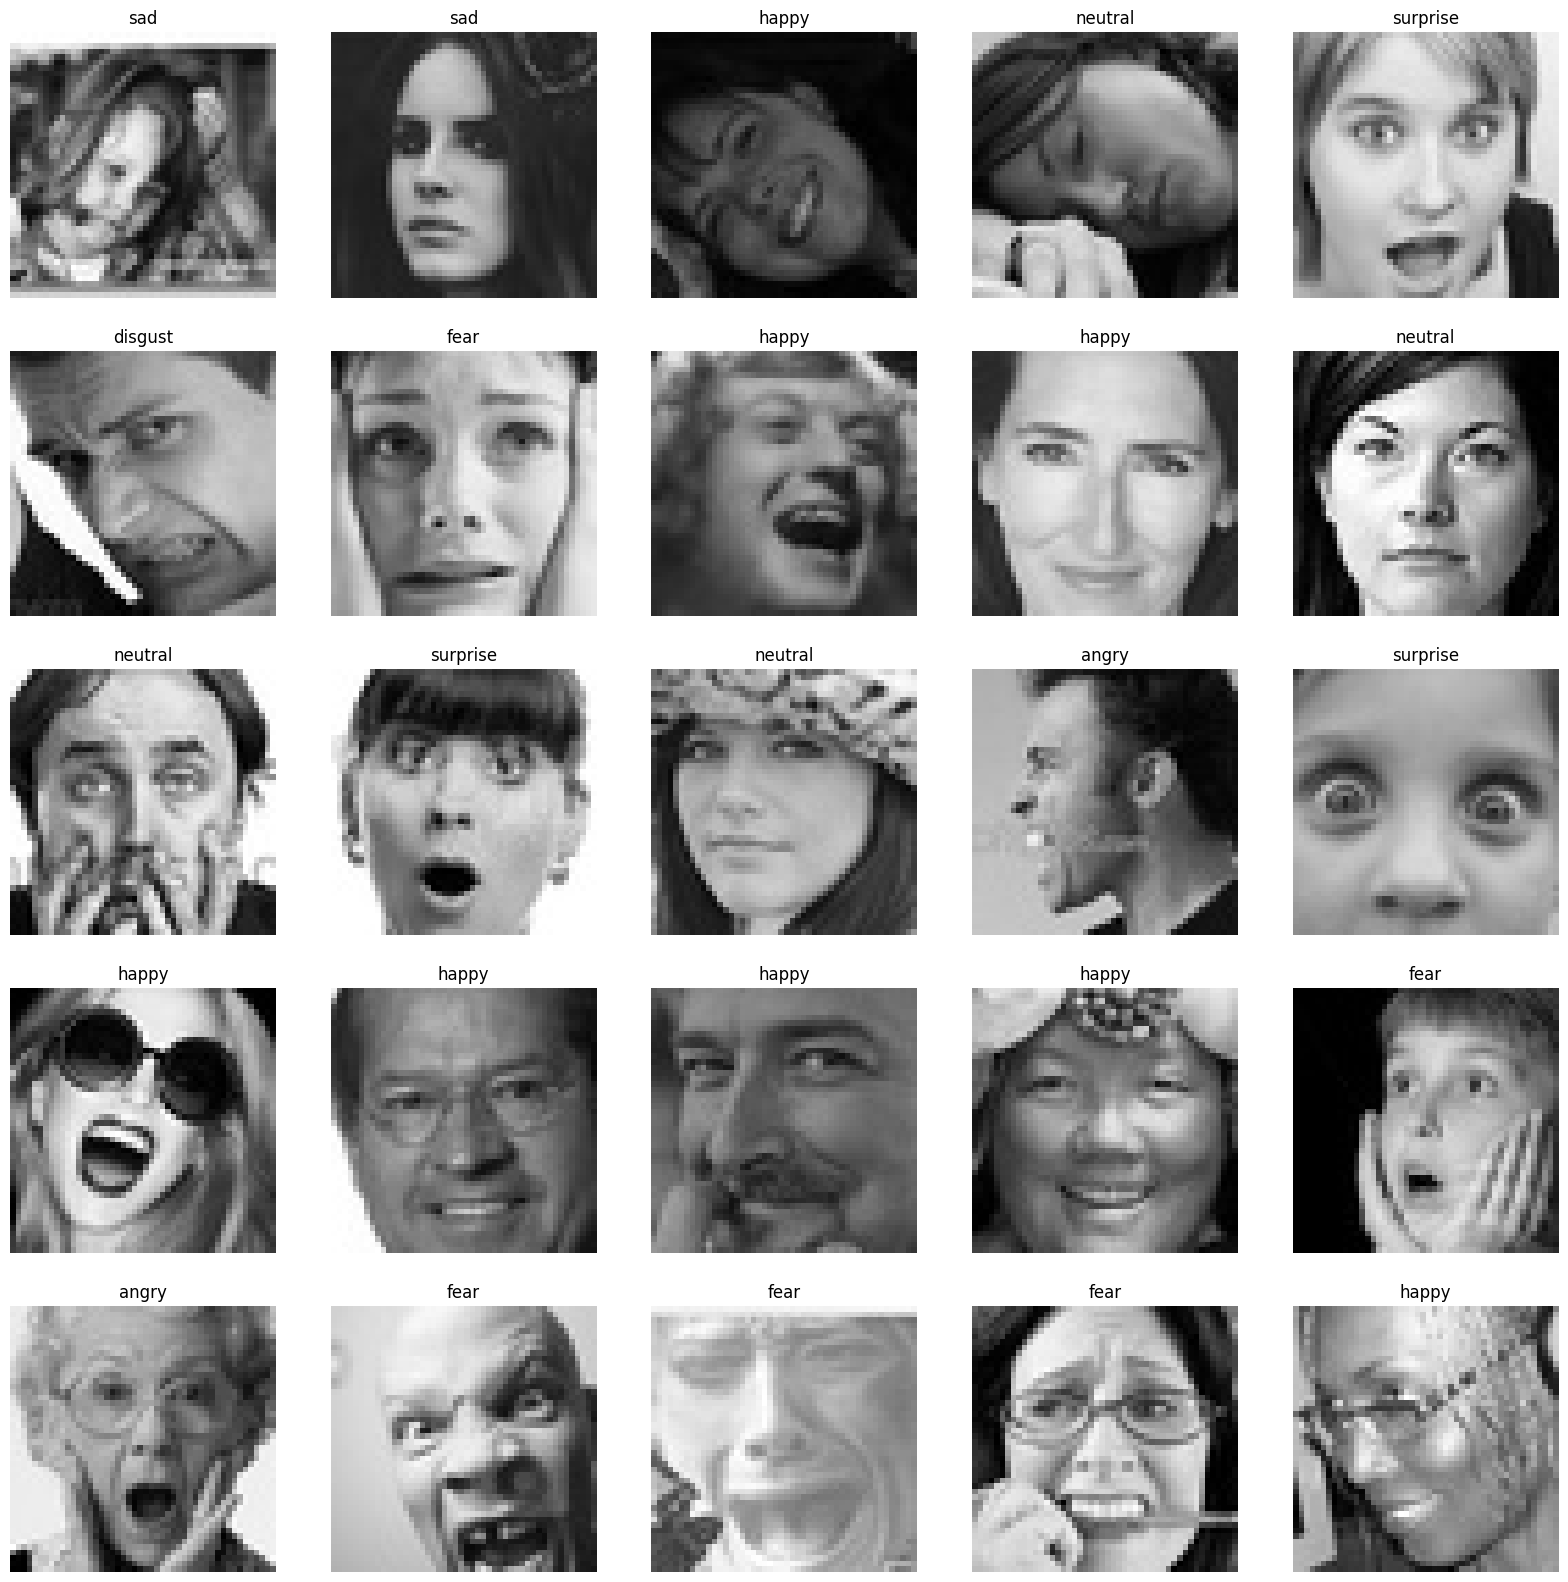

In [9]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [27]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [28]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [29]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [30]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [31]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [32]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [33]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.])

In [34]:
# config
input_shape = (224, 224, 1)
output_class = 7

In [38]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def VGG_Face_Modified(input_shape=(48, 48, 1)):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Block 5
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(512, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(4096))
    model.add(layers.Activation('relu'))
    
    # Final layer (adapt it to your task)
    model.add(layers.Dense(7))  # For 7 emotion classes, change it as needed
    model.add(layers.Activation('softmax'))

    return model

# Create the modified VGG-Face model
model = VGG_Face_Modified()
model.summary()
optimizer = Adam(learning_rate=1e-5)  # Try a smaller value
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_64 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_68 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_69 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_70 (Activation)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_71 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_72 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_73 (Activation)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,80

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=16, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.2588 - loss: 1.8016 - val_accuracy: 0.3564 - val_loss: 1.6079
Epoch 2/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.3795 - loss: 1.5687 - val_accuracy: 0.3976 - val_loss: 1.5057
Epoch 3/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.4161 - loss: 1.4725 - val_accuracy: 0.4349 - val_loss: 1.4330
Epoch 4/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.4489 - loss: 1.4007 - val_accuracy: 0.4586 - val_loss: 1.3822
Epoch 5/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.4747 - loss: 1.3423 - val_accuracy: 0.4831 - val_loss: 1.3294
Epoch 6/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.5010 - loss: 1.2856 - val_accuracy: 0.4634 - val_loss: 1.4130
Epoch 7/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.5279 - loss: 1.2176 - val_accuracy: 0.5096 - val_loss: 1.2761
Epoch 8/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.5567 -

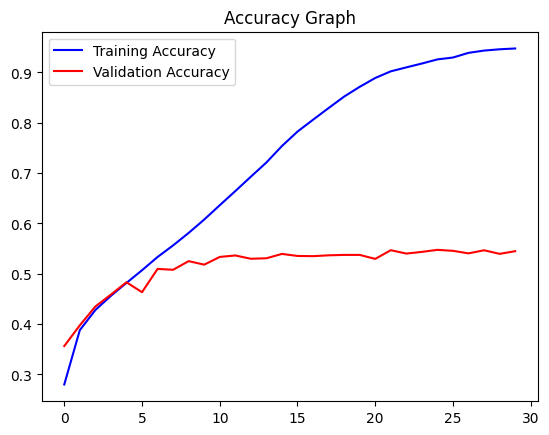

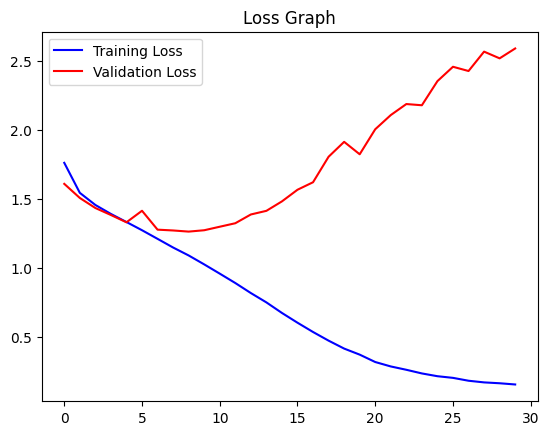

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

Original Output: happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Output: happy


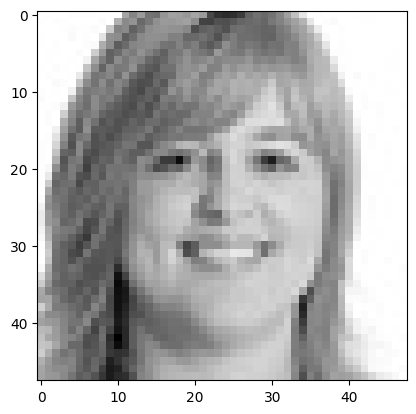

In [43]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [44]:
import joblib
joblib.dump(model, 'my_model.pkl')  # Save your model


['my_model.pkl']

In [45]:
# Assuming `model` is your Keras model
model.save('my_model.h5')  # Save the model in H5 format
